# Individual video analytics: action and watching session levels

First, we specify course name, video name, and subset of data (all, on-campus = WEBAUTH, or distant learning = ONECE) that we want to process.

In [78]:
#coursename = 'CS229'
#videoname = 'CS22922Sep2014'
#coursename = 'CS107_ClassX'
#videoname = 'CS10706Jan2014_Introduction_to_C_Nuances'
#videoname = 'CS10707Feb2014_Load_Effective_Address_and_Move_abuses'
#videoname = 'CS10721Feb2014_Compilation_Tool_Chain'
coursename = 'CS110_ClassX'
#videoname = 'CS11002Apr2014_Copying_in_Unix'
#videoname = 'CS11002Apr2014_Unix_Builtins'
videoname = 'CS11002Apr2014_Full'
subset = 'all' # choose of 'all', 'WEBAUTH' or 'ONECE'

Here we import package for data analysis called 'pandas' and specify directories.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import math

In [80]:
%matplotlib inline
#Main directory contains data (this is my local machine)
#mainDir = 'C:/Users/Tee/Documents/Active/EducationProject/SEOL/VideoAnalytics/main' #(Tee's ICME local machine)
mainDir = 'C:/Users/Admin/Dropbox/Active/EducationProject/SEOL/VideoAnalytics/main' #(Tee's dropbox machine)
#Here are directories that we will work with
OutputBigDirectory = mainDir + '/output/big/'+ coursename +'/'+ videoname 
OutputSmallDirectory = mainDir + '/output/small/'+ coursename +'/'+ videoname +'/' + subset
if not os.path.exists(OutputSmallDirectory):
    os.makedirs(OutputSmallDirectory)

Pull corresponding CSV files up and important parameters in need.

In [81]:
CleanData = pd.read_csv(OutputBigDirectory+"/CleanData.csv")
CleanSessionSummary = pd.read_csv(OutputBigDirectory+"/CleanSessionSummary.csv")
CleaningSummary = pd.read_csv(mainDir + '/output/small/'+ coursename +'/'+ videoname +"/CleaningSummary.csv")
MaxSecondMarker = int(CleaningSummary.iloc[4,1])
MaxMinuteMarker = int(CleaningSummary.iloc[5,1])

In [82]:
[MaxSecondMarker, MaxMinuteMarker]

[2926, 48]

Select data to analyze according to subset.

In [83]:
if subset == 'WEBAUTH':
    CleanData = CleanData[CleanData.UserType=='WEBAUTH']
    CleanSessionSummary = CleanSessionSummary[CleanSessionSummary.UserType=='WEBAUTH']
if subset == 'ONECE':
    CleanData = CleanData[CleanData.UserType=='ONECE']
    CleanSessionSummary = CleanSessionSummary[CleanSessionSummary.UserType=='ONECE']

In [84]:
#Create new data frame for summary
Essential = pd.DataFrame({'Key':['Course Name'],'Value':[coursename]})
Essential.loc[Essential.shape[0]] = ['Video Name',videoname]
Essential.loc[Essential.shape[0]] = ['Subset',subset]

We can analyze data from each video at action level, watching session level, and user level. Keep two themes in mind:

(1) How does analysis imply about video (overall quality and attractiveness, specific good/bad part)?

(2) How does analysis imply about students (students behavior, learning strategies, signs of boredom/inefficient learning)?

## Analysis at action level: pauses and jumps

First we look at pause. We look where 'Pause' actions take place in video timeline. Note that 'Pause' action appears very often during the first minute of videos. Pause location might indicate where video needs special attention.

Then we look at 'Pause' lengths. The pause length tends to be less than a minute. Pause length might indicate the toughness of video (students need to take more time to digest material, for example). We record "boxplot" to do cross-video comparison later.

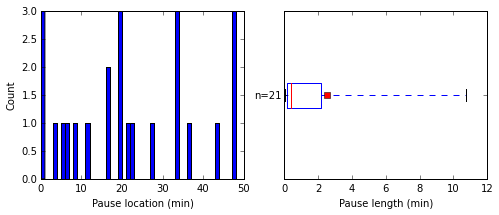

In [85]:
#setup subplot template for pauses. There will be two subplots
plt.figure(1)

plt.subplot(121)
#Pause location in video timeline
plt.hist(list(CleanData[CleanData.VideoActionTypeName=='Pause'].StartTime/60), bins=range(0,MaxMinuteMarker+2))
plt.xlabel('Pause location (min)')
plt.ylabel('Count')

plt.subplot(122)
#'Pause' length
l = list(CleanData[CleanData.StepType=='Break'].UserStepLength/60)
plt.boxplot(l, showmeans = True, vert = False, whis = [5,95], showfliers=False)
plt.yticks([1],['n='+str(len(l))])
#plt.hist(l, bins=range(0,int(math.ceil(np.max(l)))+1))
plt.xlabel('Pause length (min)')

fig = plt.gcf()
fig.set_size_inches(4*2,3)
#save figure
filename = '01Pause_'+videoname +'.png'
fig.savefig(os.path.join(OutputSmallDirectory, filename),dpi=100)
fig.show()

#collect statistics of pause length
Essential.loc[Essential.shape[0]] = ['Pause length: number', len(l)]
Essential.loc[Essential.shape[0]] = ['Pause length: mean', np.mean(l)]
Essential.loc[Essential.shape[0]] = ['Pause length: 5% tile', np.percentile(l,5)]
Essential.loc[Essential.shape[0]] = ['Pause length: 25% tile', np.percentile(l,25)]
Essential.loc[Essential.shape[0]] = ['Pause length: median', np.median(l)]
Essential.loc[Essential.shape[0]] = ['Pause length: 75% tile', np.percentile(l,75)]
Essential.loc[Essential.shape[0]] = ['Pause length: 95% tile', np.percentile(l,95)]

Now we look at jump. Let's look at jump location. We look where 'Jump' actions take place in video timeline. Unlike pause, each jump has two location entries: where jump starts and lands in video timeline. We create 2-dimensional histogram to represent jump locations. Notice that there are two trends in jump behavior: 

(1) jumps starts within the first minute. The landing location tends to be in early minutes and laters minutes of video (vertical line on the left).

(2) gradual small jumps throughout the videos (diagonal line). Note that small jumps occur most often close to the beginning and the end of video.

It is interesting to see where jump starting within the first minute lands (trend 1). We create one histogram of jump land location in the first watching session of users and another histogram for other watching sessions. 

Note that histogram for first watching sessions might suggest generic strategies to navigate a video (do small jumps in a discrete way). The shift of distributiion of other watching sessions might suggest different stategy to navigate a video (do longer jumps toward target part of video). Distribution of jump land location in other watching sessions might imply which part of video is worth watching.

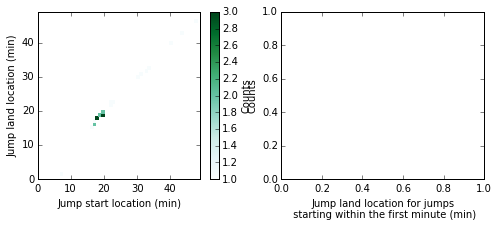

In [86]:
#setup subplot template for jump locations. There will be two subplots
plt.figure(2)

#Jump start and land location
plt.subplot(121)
x = list(CleanData[CleanData.VideoActionTypeName=='Jump'].StartTime/60)
y = list(CleanData[CleanData.VideoActionTypeName=='Jump'].EndTime/60)
H, xedges, yedges = np.histogram2d(x,y, bins = MaxMinuteMarker+2)
H = np.rot90(H)
H = np.flipud(H)
Hmasked = np.ma.masked_where(H==0,H) #Mask pixels with value ofzero
#plot 2D hispogram
plt.pcolormesh(xedges,yedges, Hmasked,cmap="BuGn")
plt.xlabel('Jump start location (min)')
plt.ylabel('Jump land location (min)')
plt.xlim(0, MaxMinuteMarker+1)
plt.ylim(0, MaxMinuteMarker+1)
#plt.axis('equal')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
#plt.show()

plt.subplot(122)
#jump land location for jumps starting within the first minute of video.
d1 = list(CleanData[(CleanData.SessionNumberByUser==0)&(CleanData.VideoActionTypeName=='Jump')&(CleanData.StartTime/60<=1)].EndTime/60)
d2 = list(CleanData[(CleanData.SessionNumberByUser>0)&(CleanData.VideoActionTypeName=='Jump')&(CleanData.StartTime/60<=1)].EndTime/60)
if len(d1)>0:
    plt.hist(d1, bins=range(0,MaxMinuteMarker+1),  alpha=0.5, label = 'first session')
if len(d2)>0:
    plt.hist(d2, bins=range(0,MaxMinuteMarker+1),  alpha=0.5, label = 'other sessions')
plt.legend(loc='upper right')
plt.xlabel('Jump land location for jumps\n starting within the first minute (min)')
plt.ylabel('Counts')

fig = plt.gcf()
fig.set_size_inches(4*2,3)
#save figure
filename = '02JumpLocation_'+videoname +'.png'
fig.savefig(os.path.join(OutputSmallDirectory, filename),dpi=100)
fig.show()

If we look at jump distance in video timeline, we can see asymmetry in jumps especially for small jumps. Note that most jump distances are small and tend to be forward. In short, students tend to jump forward with small distance to navigate the video. For video quality, the distribution might imply toughness of videos. For example, long backward jumps might imply that the instructor speaks too fast. Long forward jumps imply that instructor speaks too slow. We record "boxplot" to do cross-video comparison later.

In [87]:
#setup subplot template for jump locations. There will be three subplots
plt.figure(3)

plt.subplot(131)
#'Jump' distance
l = list((CleanData[CleanData.VideoActionTypeName=='Jump'].EndTime-CleanData[CleanData.VideoActionTypeName=='Jump'].StartTime)/60)
plt.boxplot(l, showmeans = True, vert = False, whis = [5,95], showfliers=False)
#plt.hist(l, bins=range(int(math.floor(np.min(l))),int(math.ceil(np.max(l)))+1))
plt.xlabel('Jump distance (min)')
plt.yticks([1],['n='+str(len(l))])

plt.subplot(132)
#'Jump' forward distance
lforward = [i for i in l if i >= 0]
if len(lforward)>0:
    plt.boxplot(lforward, showmeans = True, vert = False, whis = [5,95], showfliers=False)
    #plt.hist(l, bins=range(int(math.floor(np.min(l))),int(math.ceil(np.max(l)))+1))
    plt.xlabel('Jump forward distance (min)')
    plt.yticks([1],['n='+str(len(lforward))])

plt.subplot(133)
#'Jump' backward distance
lbackward = [i for i in l if i < 0]
if len(lforward)>0:
    plt.boxplot(lbackward, showmeans = True, vert = False, whis = [5,95], showfliers=False)
    #plt.hist(l, bins=range(int(math.floor(np.min(l))),int(math.ceil(np.max(l)))+1))
    plt.xlabel('Jump backward distance (min)')
    plt.yticks([1],['n='+str(len(lbackward))])

fig = plt.gcf()
fig.set_size_inches(4*3,3)
#save figure
filename = '03JumpDistance_'+videoname +'.png'
fig.savefig(os.path.join(OutputSmallDirectory, filename),dpi=100)
fig.show()

#collect statistics of jump distance
Essential.loc[Essential.shape[0]] = ['Jump distance: number', len(l)]
Essential.loc[Essential.shape[0]] = ['Jump distance: mean', np.mean(l)]
Essential.loc[Essential.shape[0]] = ['Jump distance: 5% tile', np.percentile(l,5)]
Essential.loc[Essential.shape[0]] = ['Jump distance: 25% tile', np.percentile(l,25)]
Essential.loc[Essential.shape[0]] = ['Jump distance: median', np.median(l)]
Essential.loc[Essential.shape[0]] = ['Jump distance: 75% tile', np.percentile(l,75)]
Essential.loc[Essential.shape[0]] = ['Jump distance: 95% tile', np.percentile(l,95)]

Essential.loc[Essential.shape[0]] = ['Jump distance forward: number', len(lforward)]
if len(lforward)>0:
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: mean', np.mean(lforward)]
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: 5% tile', np.percentile(lforward,5)]
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: 25% tile', np.percentile(lforward,25)]
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: median', np.median(lforward)]
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: 75% tile', np.percentile(lforward,75)]
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: 95% tile', np.percentile(lforward,95)]
else:
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: mean', 'NaN']
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: 5% tile', 'NaN']
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: 25% tile', 'NaN']
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: median', 'NaN']
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: 75% tile', 'NaN']
    Essential.loc[Essential.shape[0]] = ['Jump distance forward: 95% tile', 'NaN']

Essential.loc[Essential.shape[0]] = ['Jump distance backward: number', len(lbackward)]
if len(lbackward)>0:
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: mean', np.mean(lbackward)]
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: 5% tile', np.percentile(lbackward,5)]
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: 25% tile', np.percentile(lbackward,25)]
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: median', np.median(lbackward)]
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: 75% tile', np.percentile(lbackward,75)]
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: 95% tile', np.percentile(lbackward,95)]
else:
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: mean', 'NaN']
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: 5% tile', 'NaN']
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: 25% tile', 'NaN']
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: median', 'NaN']
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: 75% tile', 'NaN']
    Essential.loc[Essential.shape[0]] = ['Jump distance backward: 95% tile', 'NaN']


SyntaxError: invalid syntax (<ipython-input-87-41c43a3c823a>, line 58)

## Analysis at watching session level: 6-minute rule

$\textit{Subplot 1}$ First, we would like to see the distribution of user time spent in each watching session (total and watch only). The magic number we want to compare with Guo, Kim and Rubin, 2014 ("6-Minute rule" paper) is the median. Here one can see that our result is significantly different from 6 minutes. This confirms different behavior of students from MOOCs. The length of session might imply the attractiveness of video. We record "boxplot" to do cross-video comparison later.

$\textit{Subplot 2}$ One quantity of interest is ratio of user watch time and total user time in each watching session. This quantiity might indicate the toughness of video. Low value of this ratio means that student spends more time to pause and navigate video rather than watching. We record object "boxplot" to do cross-video comparison later.

$\textit{Subplot 3}$ Another interesting quantities are how often jumps and pauses occur. We can find such frequency by counting number of those actions per watching session. These quantities might also imply toughness of video. We record object "boxplot" to do cross-video comparison later.

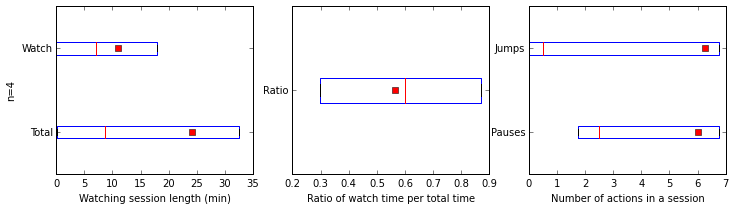

In [90]:
#setup subplot template for jumps. There will be three subplots
plt.figure(4)

plt.subplot(131)
#total time and watch time in each session
d1 = list(CleanSessionSummary.TotalUserWatchTime/60)
d2 = list(CleanSessionSummary.TimestampDiff/60)
#bins = range(0,int(math.ceil(np.max(d2)))+1)
#plt.hist(d1, bins, alpha=0.5, label='User Watch Time')
#plt.hist(d2, bins, alpha=0.5, label='User Total Time')

data = np.asarray([d2,d1]).T
labels = ['Total','Watch']
plt.boxplot(data, labels = labels, showmeans = True, vert = False, whis = [5,95], showfliers=False)
#plt.hist(l, bins=range(int(math.floor(np.min(l))),int(math.ceil(np.max(l)))+1))
plt.xlabel('Watching session length (min)')
plt.ylabel('n='+str(len(d1)))

#collect statistics of session length
Essential.loc[Essential.shape[0]] = ['number of sessions in consideration', len(d2)]
Essential.loc[Essential.shape[0]] = ['Session length total: mean', np.mean(d2)]
Essential.loc[Essential.shape[0]] = ['Session length total: 5% tile', np.percentile(d2,5)]
Essential.loc[Essential.shape[0]] = ['Session length total: 25% tile', np.percentile(d2,25)]
Essential.loc[Essential.shape[0]] = ['Session length total: median', np.median(d2)]
Essential.loc[Essential.shape[0]] = ['Session length total: 75% tile', np.percentile(d2,75)]
Essential.loc[Essential.shape[0]] = ['Session length total: 95% tile', np.percentile(d2,95)]

Essential.loc[Essential.shape[0]] = ['Session length watch: mean', np.mean(d1)]
Essential.loc[Essential.shape[0]] = ['Session length watch: 5% tile', np.percentile(d1,5)]
Essential.loc[Essential.shape[0]] = ['Session length watch: 25% tile', np.percentile(d1,25)]
Essential.loc[Essential.shape[0]] = ['Session length watch: median', np.median(d1)]
Essential.loc[Essential.shape[0]] = ['Session length watch: 75% tile', np.percentile(d1,75)]
Essential.loc[Essential.shape[0]] = ['Session length watch: 95% tile', np.percentile(d1,95)]

plt.subplot(132)
#ratio of watch time and total time in each session
d = list(CleanSessionSummary.TotalUserWatchTime/CleanSessionSummary.TimestampDiff)
plt.boxplot(d, showmeans = True, vert = False, whis = [5,95], showfliers=False)
plt.xlabel('Jump distance (min)')
#plt.hist(d)
plt.xlabel('Ratio of watch time per total time')
plt.yticks([1],['Ratio'])

#collect some statistics on ratio of total time and watch time in each session
Essential.loc[Essential.shape[0]] = ['Session length ratio: mean', np.mean(d)]
Essential.loc[Essential.shape[0]] = ['Session length ratio: 5% tile', np.percentile(d,5)]
Essential.loc[Essential.shape[0]] = ['Session length ratio: 25% tile', np.percentile(d,25)]
Essential.loc[Essential.shape[0]] = ['Session length ratio: median', np.median(d)]
Essential.loc[Essential.shape[0]] = ['Session length ratio: 75% tile', np.percentile(d,75)]
Essential.loc[Essential.shape[0]] = ['Session length ratio: 95% tile', np.percentile(d,95)]

plt.subplot(133)
#number of jumps/pauses per watching session
d1 = list(CleanSessionSummary.NumJumps)
d2 = list(CleanSessionSummary.NumPauses)

data = np.asarray([d2,d1]).T
labels = ['Pauses','Jumps']
plt.boxplot(data, labels = labels, showmeans = True, vert = False, whis = [5,95], showfliers=False)
#plt.hist(l, bins=range(int(math.floor(np.min(l))),int(math.ceil(np.max(l)))+1))
plt.xlabel('Number of actions in a session')

#collect some statistics on number of pauses/jumps in each session
Essential.loc[Essential.shape[0]] = ['In session num pauses: mean', np.mean(d2)]
Essential.loc[Essential.shape[0]] = ['In session num pauses: 5% tile', np.percentile(d2,5)]
Essential.loc[Essential.shape[0]] = ['In session num pauses: 25% tile', np.percentile(d2,25)]
Essential.loc[Essential.shape[0]] = ['In session num pauses: median', np.median(d2)]
Essential.loc[Essential.shape[0]] = ['In session num pauses: 75% tile', np.percentile(d2,75)]
Essential.loc[Essential.shape[0]] = ['In session num pauses: 95% tile', np.percentile(d2,95)]

Essential.loc[Essential.shape[0]] = ['In session num jumps: mean', np.mean(d1)]
Essential.loc[Essential.shape[0]] = ['In session num jumps: 5% tile', np.percentile(d1,5)]
Essential.loc[Essential.shape[0]] = ['In session num jumps: 25% tile', np.percentile(d1,25)]
Essential.loc[Essential.shape[0]] = ['In session num jumps: median', np.median(d1)]
Essential.loc[Essential.shape[0]] = ['In session num jumps: 75% tile', np.percentile(d1,75)]
Essential.loc[Essential.shape[0]] = ['In session num jumps: 95% tile', np.percentile(d1,95)]

fig = plt.gcf()
fig.set_size_inches(4*3,3)
#save figure
filename = '04Session_'+videoname +'.png'
fig.savefig(os.path.join(OutputSmallDirectory, filename),dpi=100)
fig.show()

Let's summarize what essential information we get from each video and record it.

In [91]:
Essential

,Key,Value
0,Course Name,CS110_ClassX
1,Video Name,CS11002Apr2014_Full
2,Subset,all
3,Pause length: number,21
4,Pause length: mean,2.503012
5,Pause length: 5% tile,0.03123333
6,Pause length: 25% tile,0.1666667
7,Pause length: median,0.4065667
8,Pause length: 75% tile,2.187833
9,Pause length: 95% tile,10.748


In [92]:
#d = pd.DataFrame({'Info':list(Essential.keys()),'Value':list(Essential.values())})
#d.sort(['Info']).to_csv(OutputSmallDirectory+"/Essential.csv",index=False)
Essential.to_csv(OutputSmallDirectory+"/IndividualVideoSummary_"+subset+".csv",index=False)

## What's next?

In the next notebook, we will explore individual video summary in user level. We will combine the code above and the code in next notebook to make it as a function of coursename and videoname later.